#### Kérdések:
    hány szintet eshet az attraktor közelítése egy lépéssel?
    szabad-e az attraktort lokálisan mélyíteni? hogyan?
    delta. és deepen => hibás algoritmus?

#### Visualisation: plotly, dash

## So far only works for IFS's with SSP

In [1]:
import numpy as np
from numpy.linalg import lstsq
import scipy.optimize as opt
from bisect import insort_left

from IPython.display import clear_output
import time
import itertools
from copy import deepcopy

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go

### Init & Tools

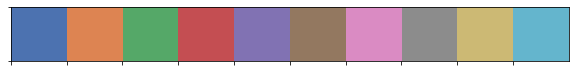

In [2]:
sns.set_palette('deep')
palette = itertools.cycle(sns.color_palette())

sns.palplot(sns.color_palette())

In [3]:
flatten = lambda li: [item for sublist in li for item in sublist]

In [4]:
def showProgress(x):
    size = 70
    done = int(x*70)
    percent = str(x*100//1) + '%'
    
    clear_output(wait=True)
    print('%s[%s%s]\n' % (percent, '#'*done, ' '*(size-done)), end='')

### Infrastructure

In [5]:
class Interval:
    def __init__(self, x, y):
        self.start = x
        self.end = y
        
    def __repr__(self):
        return "Interval" + str([self.start,self.end])
        
    def __lt__(self, other):
        return self.start < other.start
        
    def setStart(self, x):
        self.start = x
        
    def setEnd(self, x):
        self.end = x
    
    def lebesgue(self):
        return self.end - self.start
    
    def show(self,h,c,l=None):
        plt.plot([self.start,self.end],[h,h],linewidth=5,color=c,alpha=1,label=l)

In [6]:
class AffineFunction:
    def __init__(self, contraction, translation):
        self.translation = translation
        self.contraction = contraction
    
    def __lt__(self, other):
        return self.translation < other.translation
        
    def evaluate(self, x):
        return self.contraction * x + self.translation
    
    def show(self):
        c = next(palette)
        y0, y1 = [self.evaluate(0), self.evaluate(1)]
        plt.gca().add_patch(plt.Rectangle(xy=(0,y0), width=1, height=y1-y0, color=c, alpha=0.1))
        plt.plot([y0, y1], linewidth=3, color=c)

class IteratedFunctionSystem:
    def __init__(self, coefs):
        tFuncs = list(map(lambda x: AffineFunction(x[0],x[1]), coefs))
        self.functions = sorted(tFuncs)
        self.s0 = opt.brentq(lambda s: sum([affine.contraction**s for affine in tFuncs]) - 1, 0, 1)
        self.cdf = np.cumsum([affine.contraction**self.s0 for affine in tFuncs])
    
    def actOnPoint(self, x):
        rnd = np.random.random()
        idx = len(list(filter(lambda z: z<rnd, self.cdf)))
        return self.functions[idx].evaluate(x)
    
    def actOnInterval(self, interval):
        return [Interval(f.evaluate(interval.start), f.evaluate(interval.end)) for f in self.functions]
    
    def show(self):
        plt.figure(figsize=[5, 5])
        plt.axis((0, 1, 0, 1))
        [affine.show() for affine in self.functions]
        plt.show()

In [7]:
class Attractor:
    def __init__(self,ifs):
        self.ifs = ifs
        self.level = 0
        self.approx = [Interval(0,1)]
        
    def reset(self):
        self.__init__(self.ifs)
    
    def deepen(self):
        self.approx = sorted(flatten([self.ifs.actOnInterval(interval) for interval in self.approx]))
        self.level += 1
    
    def undoDeepen(self):
        size = len(ifs.functions)
        nIter = size**(self.level-1)
        self.approx = [Interval(self.approx[size*i].start, self.approx[size*(i)+size-1].end) for i in range(nIter)]
        self.level -= 1
    
    def show(self, h, c):
        [interval.show(h,c) for interval in self.approx]

class RandomWalkByIFS:
    def __init__(self, ifs):
        self.ifs = ifs
        self.position = np.random.random()
        self.orbit = [self.position] # it is the sorted list of orbit
        self.nPoints = 1
        
    def reset(self):
        self.__init__(self.ifs)
        
    def step(self):
        self.position = self.ifs.actOnPoint(self.position)
        insort_left(self.orbit, self.position)
        self.nPoints += 1

    def cover(self, delta):
        firstPoint = self.orbit[0]
        tCover = [Interval(firstPoint - delta, firstPoint + delta)]
        
        end = firstPoint + delta
        for point in self.orbit[1:]:
            if (point - delta < end):
                end = point + delta
                tCover[-1].setEnd(end)
            else:
                end = point + delta
                tCover.append(Interval(point - delta, end))
        return tCover

In [8]:
def lambdaDiff(att, cov): # might be slow
    diff = 0
    while len(cov)!=0 and len(att)!=0:
        cSlice = cov.pop(0)
        aSlice = att.pop(0)

        if (cSlice.start < aSlice.start):
            if (cSlice.end < aSlice.end):
                aSlice.setStart(max(cSlice.end, aSlice.start))
                att.insert(0, aSlice)
            else:
                cov.insert(0, cSlice)
        else:
            if (cSlice.end < aSlice.end):
                diff += cSlice.start - aSlice.start
                aSlice.setStart(cSlice.end)
                att.insert(0, aSlice)
            else:
                cov.insert(0, cSlice)
                aSlice.setEnd(min(cSlice.start, aSlice.end))
                diff += aSlice.lebesgue()

    diff += att[0].lebesgue() if (len(att)!=0) else 0
    return diff

def uncovered(delta, attractor, rw):
    att = deepcopy(attractor.approx)
    cov = rw.cover(delta)
    return lambdaDiff(att,cov)

def getDelta(att, rw, acc=10):
    return opt.brentq(lambda delta: (uncovered(delta, att, rw)==0)-.5, 0, 1, xtol=10**(-acc))

In [9]:
def run(attractor, rw, nIter=100, accuracy=10):
    start_time = time.time()

    liDelta = [(1,max(rw.position, 1-rw.position))]

    for i in range(nIter):
        rw.step()
        newDelta = getDelta(att=attractor, rw=rw, acc=accuracy)
        if ((liDelta[-1][1] - newDelta) > 10**(-accuracy)):
            test = True
            while test:
                attractor.deepen()
                tDelta = getDelta(att=attractor, rw=rw, acc=accuracy)
                test = (newDelta - tDelta) > 10**(-accuracy)
                newDelta = tDelta
            liDelta.append((rw.nPoints,newDelta))
            attractor.undoDeepen()
        showProgress((i+1)/nIter)
    print("--- Finished in %s seconds ---" % ((time.time() - start_time)//1))
    return liDelta

### Code

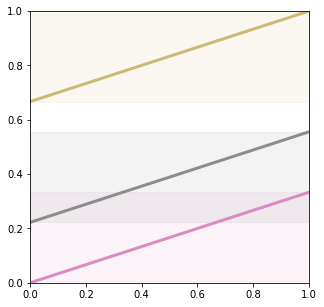

In [45]:
coefsA = [(1/3, 0), (1/4, 3/4)]
coefsB = [(1/3, 0),(1/3, np.sqrt(2)/4),(1/3,2/3)]
coefsC = [(1/3, 0),(1/3, 2/9),(1/3,2/3)]
# coefs = [(1/3, 0), (1/3, 2/3)]
coefs = [(1/2, 0), (1/4, 3/4)]
# coefs = [(1/5, 0), (1/3, 2/3), (1/10, 1/2), (1/7, 1/4)]

ifs = IteratedFunctionSystem(coefsC)
attractor = Attractor(ifs)
rw = RandomWalkByIFS(ifs)

ifs.show()

In [49]:
attractor.reset()
rw.reset()
deltas = run(attractor=attractor, rw=rw, nIter=5000)
deltaLog = np.log10(deltas).transpose()

100.0%[######################################################################]
--- Finished in 329.0 seconds ---


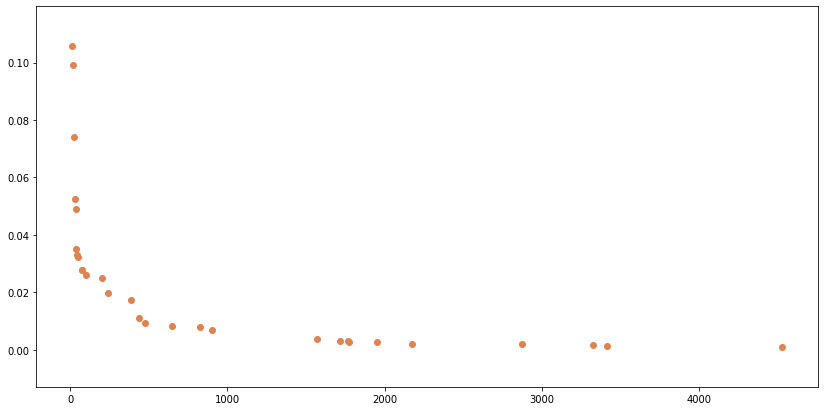

In [50]:
x = [x for (x,y) in deltas]
y = [y for (x,y) in deltas]
start = 5

plt.figure(figsize=(14,7))
plt.scatter(x[start:-1], y[start:-1], color=next(palette))
plt.show()

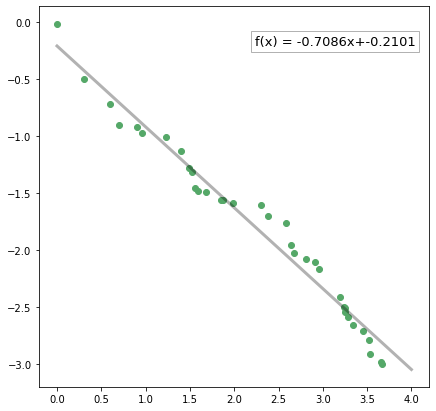

In [51]:
deltaLog = np.log10(deltas).transpose()

m, c = np.polyfit(deltaLog[0], deltaLog[1], 1)

xn = range(int(max(deltaLog[0])+2))
yn = np.polyval([m, c], xn)

plt.figure(figsize=(7,7))
# plt.axis((-0.2, 4.2, -3.3, 0))
plt.scatter(deltaLog[0], deltaLog[1], color=next(palette))
plt.plot(xn, yn, color='Black', alpha=0.3, linewidth=3)
plt.text(2.23, -0.2, 'f(x) = {:.4f}x+{:.4f}'.format(m,c), fontsize=13, bbox=dict(facecolor='white', alpha=0.3))
plt.show()

#### Visualization of algorithm over a short path

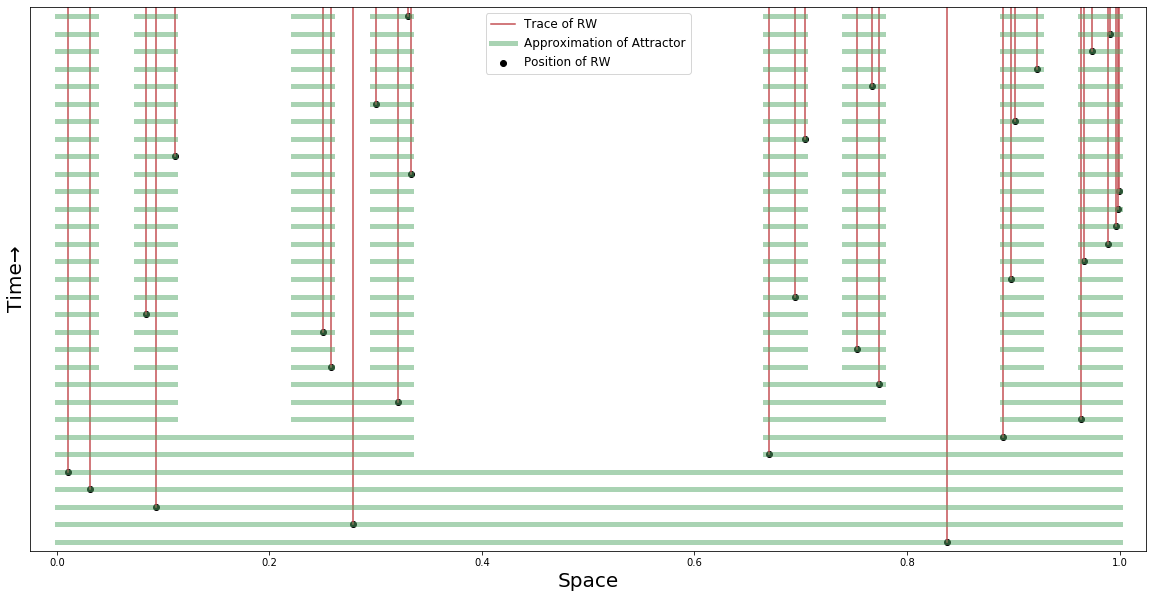

In [839]:
attractor.reset()
rw.reset()

accuracy = 10
liDelta = [max(rw.position, 1-rw.position)]
n=30

plt.figure(figsize=(20,10))
plt.axis((-.025, 1.025, -.5, n+.5))
plt.xlabel('Space', size=20)
plt.ylabel('Time→', size=20)
plt.yticks([])

plt.plot([rw.position, rw.position],[0,n+1], color=sns.color_palette()[3], label='Trace of RW')
plt.scatter([rw.position], [0],color='Black', label='Position of RW')
Interval(0,1).show(h=0, c=sns.color_palette()[2], l='Approximation of Attractor')

# plt.legend(ncol=3,fontsize=12,bbox_to_anchor=(0.5,1.03),loc='center')
# plt.legend(fontsize=12,bbox_to_anchor=(0.625,0.9),loc='center')
plt.legend(fontsize=12,loc=9)

for i in range(n):
    rw.step()
    newDelta = getDelta(att=attractor, rw=rw, acc=accuracy)
    if ((liDelta[-1] - newDelta) > 10**(-accuracy)):
        test = True
        while test:
            attractor.deepen()
            tDelta = getDelta(att=attractor, rw=rw, acc=accuracy)
            test = (newDelta - tDelta) > 10**(-accuracy)
            newDelta = tDelta
        liDelta.append(newDelta)        
        attractor.undoDeepen()
    
    plt.scatter([rw.position],[i+1],color='Black')
    plt.plot([rw.position,rw.position],[i+1,n+1],color=sns.color_palette()[3])
    attractor.show(h=i+1, c=sns.color_palette()[2])

plt.show()

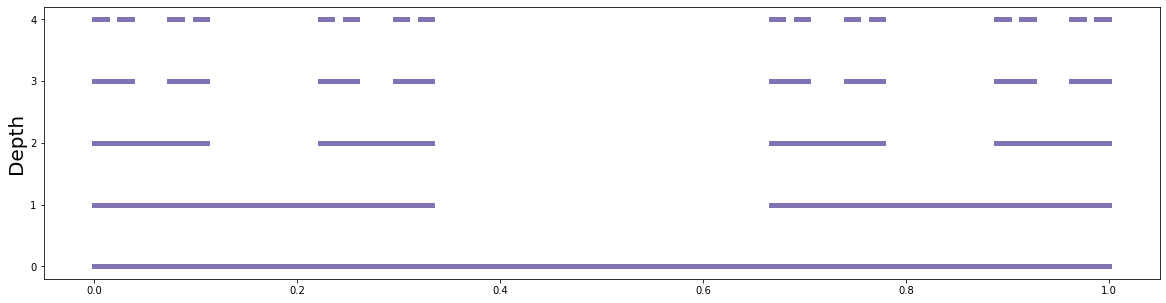

In [1015]:
attractor.reset()

plt.figure(figsize=(20,5))
plt.ylabel('Depth', size=20)
plt.yticks([0,1,2,3,4])
attractor.show(h=0, c=sns.color_palette()[4])
for i in range(4):
    attractor.deepen()
    attractor.show(h=i+1, c=sns.color_palette()[4])

In [1075]:
rw.reset()
attractor.reset()

[rw.step() for _ in range(10000)]

deltas = [getDelta(attractor,rw,acc=10)]
for i in range(15):
    attractor.deepen()
    deltas.append(getDelta(attractor,rw,acc=10))

plt.figure(figsize=(20,5))
plt.scatter(range(16),deltas,s=60,color=sns.color_palette()[9])
plt.plot([0,15],[deltas[-1],deltas[-1]],lw=3,alpha=0.6,color=sns.color_palette()[5])
plt.xlabel('Depth',size=20)
plt.show()

dgdfgd


### Sandbox

In [ ]:
attractor.deepen()

In [ ]:
rw.step()

In [165]:
getDelta(attractor, rw, acc=10)

In [104]:
start_time = time.time()
getDelta(attractor, rw, acc=10)
print("--- %s seconds ---" % (time.time() - start_time))

--- 7.174118995666504 seconds ---


In [15]:
n = 1000000

li = list(range(10))*(n)
lo = np.random.randint(10, size=n*10)

start_time = time.time()
sorted(li)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
sorted(lo)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.5790340900421143 seconds ---
--- 3.643695831298828 seconds ---


In [131]:
n = 100000

li = []
lo = []

start_time = time.time()
[li.insert(0,i) for i in range(n)]
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
for i in range(n):
    lo = [i] + lo 
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.655930280685425 seconds ---
--- 25.82972240447998 seconds ---


### Interactive Visualization

In [442]:
orbit = rw.walk(1000)
cover = Cover(.0001, orbit.points)

In [456]:
# lines of cover
xCover = flatten([[interval.start, interval.end, None] for interval in cover.cover])
yCover = flatten([[0, 0, None] for _ in cover.cover])
markerCover = dict(color='DarkGrey', size=5, line=dict(color='DarkGrey'))

# markers of orbit
markerOrbit = dict(color='Black', size=5)

# plot
toRemove = ['lasso2d','autoScale2d','toggleSpikelines','hoverCompareCartesian']
fig = go.Figure()

fig.update_layout(title_text="Delta-cover of orbit of RW generated by IFS")

fig.add_trace(go.Scatter(mode='markers', x=orbit.points, y=np.zeros(len(orbit.points)), marker=markerOrbit))
fig.add_trace(go.Scatter(x=xCover, y=yCover, marker=markerCover))
# fig.show(config={'displayModeBar': True, 'scrollZoom': True, 'modeBarButtonsToRemove': toRemove})
fig.write_html("delta_cover.html", auto_open=True)